In [1]:
#!/usr/bin/env python
# coding: utf-8

# Import libraries and model weight file location
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import itertools
from torch.utils.data import DataLoader
from IPython.display import display, clear_output
import pandas as pd
from functools import reduce
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
# sns.set()

MODEL_FILE = './models/model-4-Run(lr=0.01, batch_size=128, momentum=0.9, l1_oc=64, filter_multiplier=2, kernel_size=3, stride=1, dropout_rate=0.3)-.pth'
TOP_K = 5

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_map = dict(zip(list(range(10)), classes))

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

In [21]:
TOPK = 20
class Network(nn.Module):
    def __init__(self, l1_oc, filter_multiplier, kernel_size, stride, inp_img_shape, dropout_rate = 0):
        super().__init__()
        self.fil_mul = filter_multiplier
        self.l1_oc = l1_oc
        self.kernel_size = kernel_size
        self.num_conv_layers = 2
        self.inp_img_shape = inp_img_shape
        self.stride = stride
        self.dropout_rate = dropout_rate

        # Layers Initialization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=self.inp_img_shape[0], out_channels=self.l1_oc, kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv2 = nn.Conv2d(in_channels=self.l1_oc, out_channels=self.l1_oc, kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv3 = nn.Conv2d(in_channels=self.l1_oc, out_channels=int(self.l1_oc*(self.fil_mul)), kernel_size=self.kernel_size, stride=self.stride)
        self.conv4 = nn.Conv2d(in_channels=int(self.l1_oc*(self.fil_mul)), out_channels=int(self.l1_oc*(self.fil_mul)**2), kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv5 = nn.Conv2d(in_channels=int(self.l1_oc*(self.fil_mul)**2), out_channels=int(self.l1_oc*(self.fil_mul)**2), kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv6 = nn.Conv2d(in_channels=int(self.l1_oc*(self.fil_mul)**2), out_channels=int(self.l1_oc*(self.fil_mul)**3), kernel_size=self.kernel_size, stride=self.stride)

        self.bn1 = nn.BatchNorm2d(int(self.l1_oc), eps=1e-05, momentum=0.05, affine=True)
        self.bn2 = nn.BatchNorm2d(int(self.l1_oc), eps=1e-05, momentum=0.05, affine=True)
        self.bn3 = nn.BatchNorm2d(int(self.l1_oc*self.fil_mul), eps=1e-05, momentum=0.05, affine=True)
        self.bn4 = nn.BatchNorm2d(int(self.l1_oc*(self.fil_mul)**2), eps=1e-05, momentum=0.05, affine=True)
        self.bn5 = nn.BatchNorm2d(int(self.l1_oc*(self.fil_mul)**2), eps=1e-05, momentum=0.05, affine=True)
        self.bn6 = nn.BatchNorm2d(int(self.l1_oc*(self.fil_mul)**3), eps=1e-05, momentum=0.05, affine=True)

        # fl_img_dim is the flattened image dimension. It is determined dynamically using an input tensor of same shape as the transformed input. Required FOR ALL network implementations.
        self.fl_img_dim = list(self.forward(torch.zeros([2, *self.inp_img_shape]), get_shape=True))

        # Fully connected network layers for net 1, 2, 3 and 4. DO NOT COMMENT
        self.fc1 = nn.Linear(in_features=reduce(lambda x, y: x*y, self.fl_img_dim), out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10) 

    def forward(self, x, get_shape = False):
        filt_responses = []
        
        x = F.relu(self.bn1(self.conv1(x))) # First conv layer    
        x = F.relu(self.bn2(self.conv2(x))) # second conv layer
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # third conv layer
        x = F.relu(self.bn4(self.conv4(x))) # fourth conv layer
        x = F.relu(self.bn5(self.conv5(x))) # fifth conv layer
        x = self.pool(self.bn6(F.relu(self.conv6(x))))
        
        if get_shape:
            return x.shape[1:]
        
        x = x.view(-1, reduce(lambda x, y: x*y, self.fl_img_dim))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc3(x)    
        return x, filt_responses

In [22]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output).cuda()
    def close(self):
        self.hook.remove()

In [41]:
BS = 128
seed_everything()
# Prepare and load the test set
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
    transforms.ToTensor(),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BS,
                                        shuffle=False, num_workers=0)

# Define the model parameters (best run of net 4)                       
model = Network(64, 2, 3, 1, (3, 32, 32), 0.3)
model = model.eval()

# Load the model parameters
checkpoint = torch.load(MODEL_FILE)
model.load_state_dict(checkpoint)

# list(model.children())[7:12]

scores = dict()
flag = 1
batch_num = 1
for batch in iter(testloader):
    
    images, labels = batch
    if flag == 1:
        flag = 0
        IMAGE_PRE = images[:10]

        
    temp = dict()
    for i in range(7, 12):
        temp[i-7] = SaveFeatures(list(model.children())[i])
    
    _ = model(images)
    
    
    for i in range(7, 12):
        for j in range(0, 2):
            try:
                scores['layer_' + str(i-6)+'_'+'filt_'+str(j)] = scores.get('layer_' + str(i-6)+'_'+'filt_'+str(j), []) + list(torch.sum(temp[i-7].features[:, j].view(BS, -1), dim=1).tolist())
            except:
                scores['layer_' + str(i-6)+'_'+'filt_'+str(j)] = scores.get('layer_' + str(i-6)+'_'+'filt_'+str(j), []) + list(torch.sum(temp[i-7].features[:, j].view(16, -1), dim=1).tolist())

    for i in range(7, 12):
        temp[i-7].close()
    
    if batch_num%10 == 0: print(str(128*batch_num)+'/10000')
    batch_num += 1

Files already downloaded and verified


C:\Users\Anoubhav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


1280/10000
2560/10000
3840/10000
5120/10000
6400/10000
7680/10000
8960/10000


In [111]:
list(model.children())[7:12]

[BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
 BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
 BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
 BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
 BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)]

In [69]:
import heapq
TOPK = 5
topk_index = dict()
topk_score = dict()
for i in range(7, 12):
    for j in range(0, 2):
        # Image index
        temp = heapq.nlargest(TOPK, range(10000), key = lambda x: scores['layer_' + str(i-6)+'_'+'filt_'+str(j)][x])
        topk_index['layer_' + str(i-6)+'_'+'filt_'+str(j)] = topk_index.get('layer_' + str(i-6)+'_'+'filt_'+str(j), []) + temp
        print(temp)

        # Image score
        temp = heapq.nlargest(TOPK, scores['layer_' + str(i-6)+'_'+'filt_'+str(j)])
        topk_score['layer_' + str(i-6)+'_'+'filt_'+str(j)] = topk_score.get('layer_' + str(i-6)+'_'+'filt_'+str(j), []) + temp
        print(temp)
#         print('\n')

[5584, 6474, 5583, 1525, 5327]
[637.593505859375, 620.7105712890625, 588.2001953125, 586.4624633789062, 586.423095703125]
[1801, 2982, 9492, 3602, 6757]
[301.4070129394531, 300.7145080566406, 291.368896484375, 289.1813049316406, 286.2054443359375]
[5631, 5303, 8077, 4527, 1999]
[399.2108154296875, 384.6556091308594, 382.76861572265625, 345.7594909667969, 341.8020935058594]
[1307, 4153, 4285, 5259, 2772]
[-12.578279495239258, -12.977533340454102, -12.999053001403809, -13.026590347290039, -13.030725479125977]
[5344, 9765, 6060, 6941, 2324]
[78.2591781616211, 74.28411865234375, 66.61543273925781, 63.24541091918945, 63.07044219970703]
[2772, 4580, 3848, 5219, 8647]
[89.45170593261719, 65.7195053100586, 63.163841247558594, 44.76842498779297, 36.89089584350586]
[6439, 7034, 9130, 1482, 683]
[107.09873962402344, 90.04776000976562, 77.03245544433594, 74.27720642089844, 73.04855346679688]
[4985, 6945, 7118, 5947, 9523]
[101.34402465820312, 99.81695556640625, 96.48971557617188, 95.28990173339844

In [72]:
# Obtaint the best images and its labels
topk_image = dict()
topk_label = dict()

torch.manual_seed(0)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                        shuffle=False, num_workers=0)
seed_everything()
flag =1

for batch in iter(testloader):
    images, labels = batch
    if flag == 1:
        flag = 2
        IMAGE_POST = images[:10]
    for i in range(7, 12):
        for j in range(0, 2):
            temp_imgs, temp_labels = np.zeros((1, 3, 32, 32)), []
            for k in topk_index['layer_' + str(i-6)+'_'+'filt_'+str(j)]:
                temp_imgs = np.vstack((temp_imgs, np.expand_dims(images[k],axis = 0)))
                temp_labels.append(labels[k].item())

            topk_image['layer_' + str(i-6)+'_'+'filt_'+str(j)] = temp_imgs[1:]
            topk_label['layer_' + str(i-6)+'_'+'filt_'+str(j)] = temp_labels

### Check if testloader is finally deterministic

In [73]:

temp = IMAGE_PRE == IMAGE_POST
np.where(temp ==0)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [75]:
temp = np.zeros((5, 3, 32, 32))
for i in range(7, 12):
    for j in range(0, 2):
#         print('layer_' + str(i-6)+'_'+'filt_'+str(j))
        temp = np.vstack((temp, topk_image['layer_' + str(i-6)+'_'+'filt_'+str(j)]))
        
all_imgs = temp[5:]
print(all_imgs.shape)

layer_1_filt_0
layer_1_filt_1
layer_2_filt_0
layer_2_filt_1
layer_3_filt_0
layer_3_filt_1
layer_4_filt_0
layer_4_filt_1
layer_5_filt_0
layer_5_filt_1
(50, 3, 32, 32)


['plane', 'ship', 'plane', 'cat', 'plane']
['deer', 'deer', 'truck', 'cat', 'deer']
['frog', 'dog', 'cat', 'cat', 'dog']
['bird', 'plane', 'car', 'plane', 'frog']
['bird', 'deer', 'cat', 'deer', 'plane']
['frog', 'frog', 'ship', 'bird', 'deer']
['cat', 'plane', 'ship', 'ship', 'ship']
['deer', 'dog', 'dog', 'dog', 'dog']
['frog', 'deer', 'deer', 'deer', 'deer']
['cat', 'deer', 'dog', 'cat', 'dog']


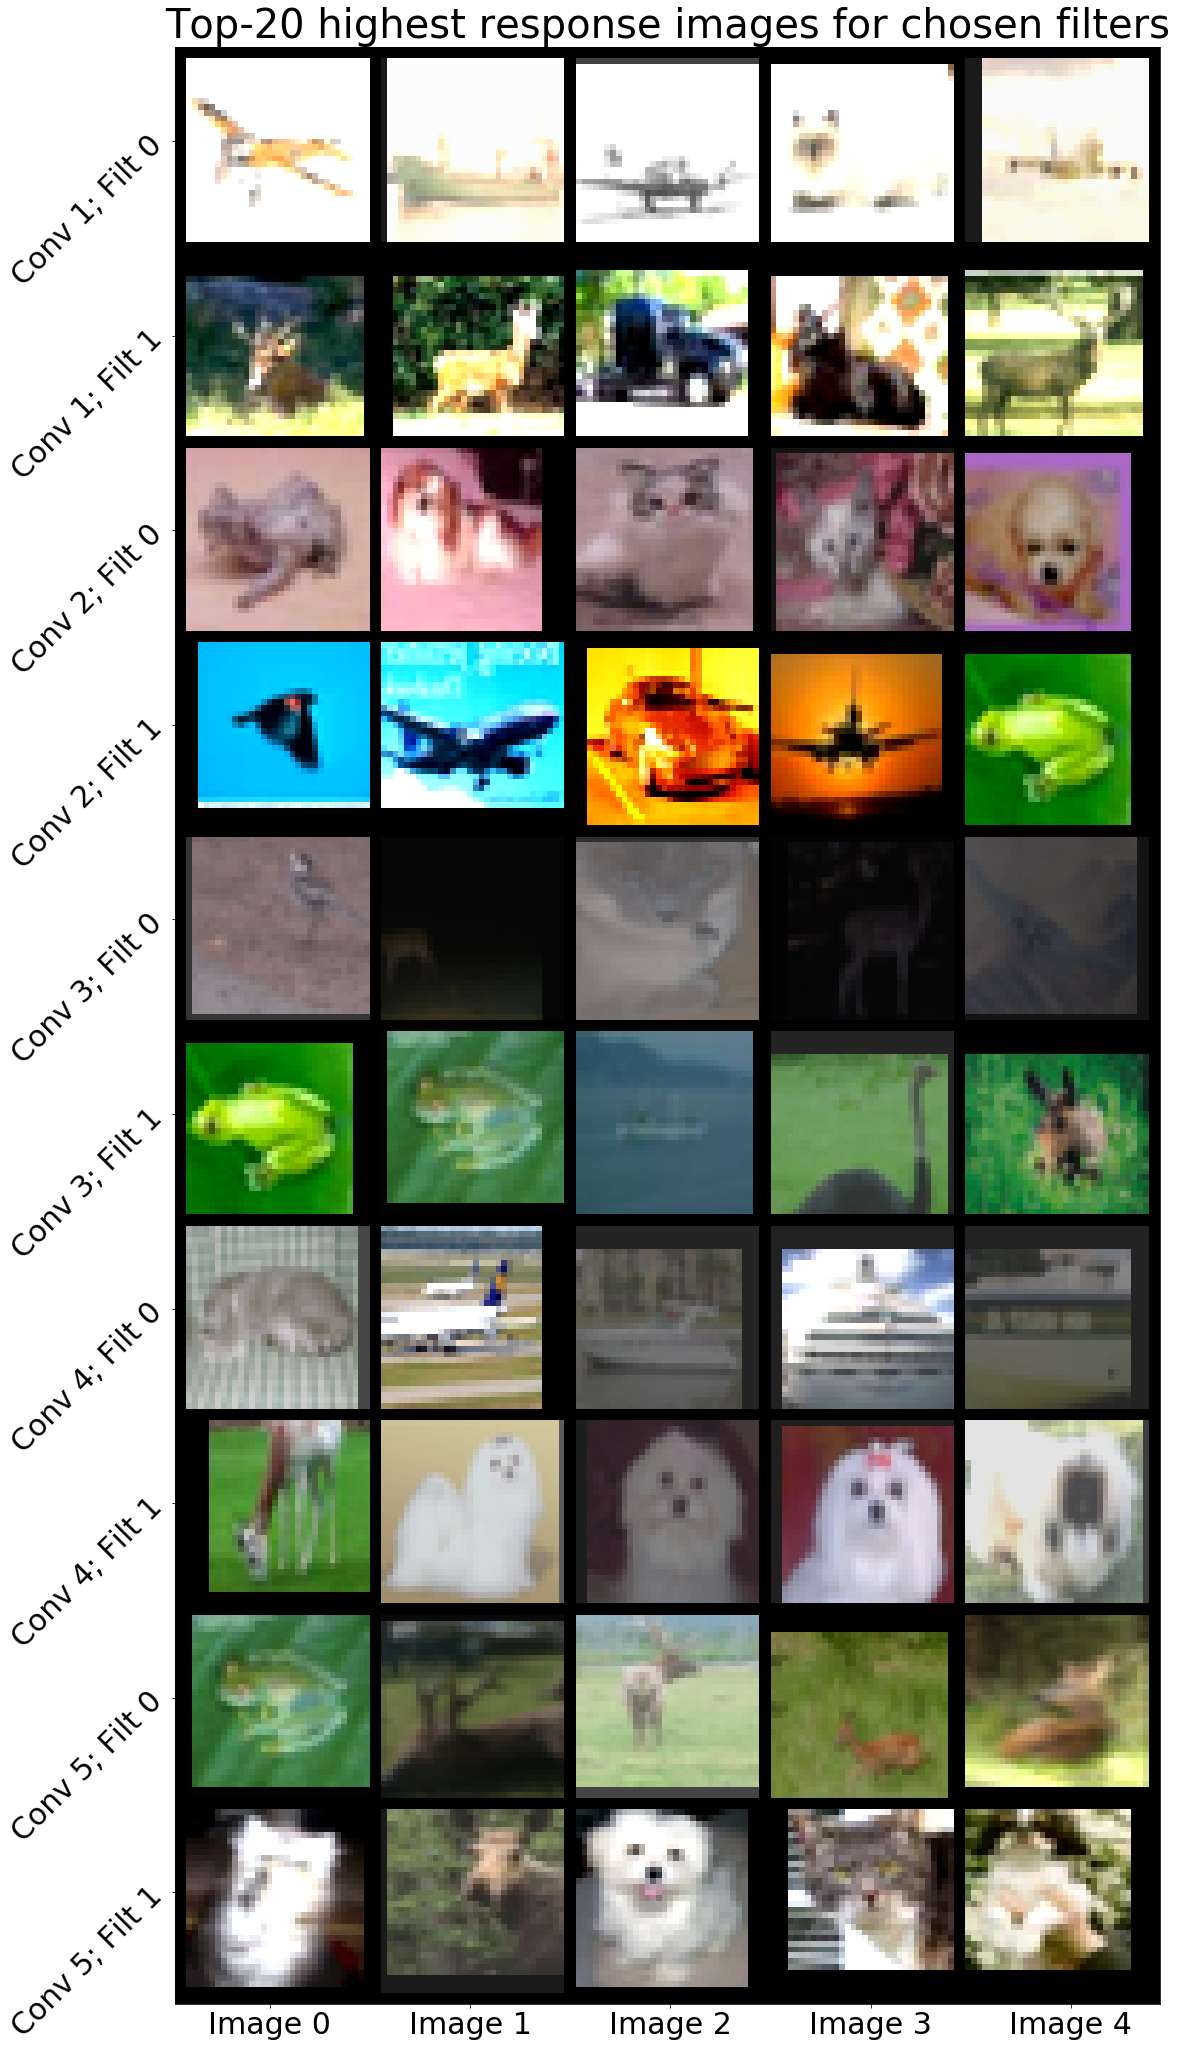

In [480]:
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.facecolor'] = 'white'
grid = torchvision.utils.make_grid(torch.tensor(all_imgs), nrow=5)

ax = plt.figure(figsize=(36,36))

plt.imshow(np.transpose(grid, (1, 2, 0)))
# plt.axis('off')
plt.yticks([16+(w)*34 for w in range(10)], 
  ['Conv {}; Filt {}'.format( [1, 1, 2, 2, 3, 3, 4, 4, 5, 5][w-1], 1 - w%2) for w in range(1, 11)], size = 30, rotation = 45)
plt.xticks([16+(w)*35 for w in range(5)], 
  ['Image %i'%w for w in range(5)], size = 30)
plt.grid(False)
plt.title('Top-{} highest response images for chosen filters'.format(TOPK), size= 40)
plt.savefig('High response images.png', bbox_inches = 'tight')

all_topk_classes = list()
for i in range(7, 12):
    for j in range(0, 2):
        temp = [class_map[k] for k in topk_label['layer_' + str(i-6)+'_'+'filt_'+str(j)]]
        print(temp)
        all_topk_classes.append(temp)

In [77]:
activations = dict()
seed_everything()
img_start, img_end = 0, 5
for i in range(7, 12):
    temp = SaveFeatures(list(model.children())[i]) 
    for j in range(0, 2):
        
        
        outputs = model(torch.tensor(all_imgs[img_start:img_end], dtype=torch.float32).clone().detach())
        
        activations['layer_' + str(i-6)+'_'+'filt_'+str(j)] = temp.features[:, j]
        
        img_start += 5
        img_end += 5
    temp.close()

C:\Users\Anoubhav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [78]:
for i in range(7, 12):
    for j in range(0, 2):
#         print('layer_' + str(i-6)+'_'+'filt_'+str(j))
#         print(activations['layer_' + str(i-6)+'_'+'filt_'+str(j)].view(5, -1).size())
        print(torch.sum(activations['layer_' + str(i-6)+'_'+'filt_'+str(j)].view(5, -1), dim=1))
#         print('\n')

tensor([637.5935, 620.7106, 588.2002, 586.4624, 586.4231], device='cuda:0')
tensor([301.4070, 300.7145, 291.3689, 289.1813, 286.2055], device='cuda:0')
tensor([399.2108, 384.6556, 382.7686, 345.7595, 341.8021], device='cuda:0')
tensor([-12.5783, -12.9775, -12.9991, -13.0266, -13.0307], device='cuda:0')
tensor([78.2592, 74.2841, 66.6154, 63.2454, 63.0704], device='cuda:0')
tensor([89.4517, 65.7195, 63.1638, 44.7684, 36.8909], device='cuda:0')
tensor([107.0987,  90.0478,  77.0325,  74.2772,  73.0486], device='cuda:0')
tensor([101.3440,  99.8170,  96.4897,  95.2899,  92.5692], device='cuda:0')
tensor([21.7569, 18.6985, 10.2234,  7.9651,  7.7791], device='cuda:0')
tensor([28.9369, 25.2451, 20.2977, 17.9514, 15.7198], device='cuda:0')


### Successfully reproduced the scores obtained from previous testloader
- [637.593505859375, 620.7105712890625, 588.2001953125, 586.4624633789062, 586.423095703125]
- [301.4070129394531, 300.7145080566406, 291.368896484375, 289.1813049316406, 286.2054443359375]
- [399.2108154296875, 384.6556091308594, 382.76861572265625, 345.7594909667969, 341.8020935058594]
- [-12.578279495239258, -12.977533340454102, -12.999053001403809, -13.026590347290039, -13.030725479125977]
- [78.2591781616211, 74.28411865234375, 66.61543273925781, 63.24541091918945, 63.07044219970703]
- [89.45170593261719, 65.7195053100586, 63.163841247558594, 44.76842498779297, 36.89089584350586]
- [107.09873962402344, 90.04776000976562, 77.03245544433594, 74.27720642089844, 73.04855346679688]
- [101.34402465820312, 99.81695556640625, 96.48971557617188, 95.28990173339844, 92.56918334960938]
- [21.756860733032227, 18.698532104492188, 10.223426818847656, 7.965125560760498, 7.7791218757629395]
- [28.936853408813477, 25.245136260986328, 20.297664642333984, 17.95137596130371, 15.719823837280273]

In [79]:
import heapq
TOPK = 20
top20_index = dict()
for i in range(7, 12):
    for j in range(0, 2):
        # Image index
        temp = heapq.nlargest(TOPK, range(10000), key = lambda x: scores['layer_' + str(i-6)+'_'+'filt_'+str(j)][x])
        top20_index['layer_' + str(i-6)+'_'+'filt_'+str(j)] = top20_index.get('layer_' + str(i-6)+'_'+'filt_'+str(j), []) + temp
        print(temp)

[5584, 6474, 5583, 1525, 5327, 1904, 1528, 7813, 4273, 8988, 1664, 2314, 1628, 5055, 3653, 8928, 6914, 4922, 3416, 3547]
[1801, 2982, 9492, 3602, 6757, 7301, 4350, 7094, 121, 3082, 4285, 9566, 4013, 5403, 9333, 4674, 3526, 3390, 2442, 3584]
[5631, 5303, 8077, 4527, 1999, 5344, 6163, 2046, 9665, 9527, 4077, 2106, 3194, 4375, 9837, 8012, 3726, 7874, 5, 8589]
[1307, 4153, 4285, 5259, 2772, 7529, 7444, 8580, 1732, 8756, 6503, 4442, 9406, 3810, 802, 8359, 8239, 2896, 2435, 8515]
[5344, 9765, 6060, 6941, 2324, 1870, 2623, 97, 6951, 1887, 7538, 9512, 3570, 4814, 4546, 1425, 3084, 3356, 8754, 7118]
[2772, 4580, 3848, 5219, 8647, 6567, 5595, 4564, 6494, 6669, 9640, 4621, 2956, 3977, 2655, 1869, 9154, 7209, 7708, 4453]
[6439, 7034, 9130, 1482, 683, 5847, 9539, 7031, 6899, 7987, 80, 4056, 9275, 9079, 1953, 6326, 9942, 6395, 9932, 312]
[4985, 6945, 7118, 5947, 9523, 3960, 8789, 1178, 2335, 9372, 8232, 5701, 7776, 6127, 3784, 2608, 2044, 7319, 5611, 1942]
[4580, 3580, 5757, 3759, 8836, 4505, 6127, 

In [84]:
all_top20_classes = list()
for i in range(7, 12):
    for j in range(0, 2):
        temp = [class_map[labels[k].item()] for k in top20_index['layer_' + str(i-6)+'_'+'filt_'+str(j)]]
        all_top20_classes.append(temp)

[['plane',
  'ship',
  'plane',
  'cat',
  'plane',
  'car',
  'bird',
  'cat',
  'dog',
  'bird',
  'plane',
  'cat',
  'deer',
  'plane',
  'ship',
  'deer',
  'ship',
  'plane',
  'horse',
  'truck'],
 ['deer',
  'deer',
  'truck',
  'cat',
  'deer',
  'frog',
  'deer',
  'deer',
  'cat',
  'horse',
  'car',
  'truck',
  'car',
  'horse',
  'plane',
  'cat',
  'deer',
  'cat',
  'deer',
  'cat'],
 ['frog',
  'dog',
  'cat',
  'cat',
  'dog',
  'bird',
  'cat',
  'cat',
  'cat',
  'frog',
  'cat',
  'dog',
  'cat',
  'cat',
  'deer',
  'cat',
  'dog',
  'frog',
  'frog',
  'dog'],
 ['bird',
  'plane',
  'car',
  'plane',
  'frog',
  'dog',
  'truck',
  'cat',
  'truck',
  'bird',
  'frog',
  'cat',
  'dog',
  'cat',
  'deer',
  'bird',
  'ship',
  'ship',
  'frog',
  'ship'],
 ['bird',
  'deer',
  'cat',
  'deer',
  'plane',
  'bird',
  'deer',
  'plane',
  'truck',
  'cat',
  'dog',
  'plane',
  'cat',
  'cat',
  'bird',
  'deer',
  'cat',
  'deer',
  'cat',
  'dog'],
 ['frog',
  'f

In [86]:
i = 1
filt_cls_num_dict = dict()
for filt_img_classes in all_top20_classes:
    for cls in classes:
        filt_cls_num_dict[i] = filt_cls_num_dict.get(i, []) + [filt_img_classes.count(cls)]
    i = i + 1
filt_cls_num_dict

df_top20_freq = pd.DataFrame(list(filt_cls_num_dict.values()), index = ['Conv {}; Filt {}'.format([1, 1, 2, 2, 3, 3, 4, 4, 5, 5][w-1], 1 - w%2) for w in range(1, 11)], columns=classes)
df_top20_freq['max_class'] = df_top20_freq.idxmax(axis=1).values

df_top20_freq = df_top20_freq.rename_axis('Filter type')
# df_top20_freq

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,max_class
Filter type,,,,,,,,,,,
Conv 1; Filt 0,6,1,2,3,2,1,0,1,3,1,plane
Conv 1; Filt 1,1,2,0,5,7,0,1,2,0,2,deer
Conv 2; Filt 0,0,0,1,9,1,5,4,0,0,0,cat
Conv 2; Filt 1,2,1,3,3,1,2,3,0,3,2,bird
Conv 3; Filt 0,3,0,3,6,5,2,0,0,0,1,cat
Conv 3; Filt 1,4,0,3,1,4,2,3,0,3,0,plane
Conv 4; Filt 0,5,1,1,1,1,0,0,2,9,0,ship
Conv 4; Filt 1,0,0,4,2,2,10,1,1,0,0,dog
Conv 5; Filt 0,0,0,5,0,10,1,2,2,0,0,deer


In [95]:
import heapq
TOPK = 20
top20_score = dict()
for i in range(7, 12):
    for j in range(0, 2):
        # Image score
        temp = heapq.nlargest(TOPK, scores['layer_' + str(i-6)+'_'+'filt_'+str(j)])
        top20_score['layer_' + str(i-6)+'_'+'filt_'+str(j)] = top20_score.get('layer_' + str(i-6)+'_'+'filt_'+str(j), []) + temp
#         print(temp)
#         print(sum(temp)/20)
#         print('\n')

578.7719879150391
285.0013031005859
332.0978668212891
-13.13187804222107
52.39362049102783
29.04249267578125
67.93363590240479
87.87403869628906
4.010550770163536
11.50444049835205


In [482]:
df_avg_response = pd.DataFrame({'Patch size': [3, 3, 5, 5, 7, 7, 13, 13, 17, 17]},index = ['Conv {}; Filt {}'.format([1, 1, 2, 2, 3, 3, 4, 4, 5, 5][w-1], 1 - w%2) for w in range(1, 11)])
df_avg_response = df_avg_response.rename_axis('Filter type')

(df_avg_response.style.
background_gradient(subset='Patch size', cmap='Greens'))

,Patch size
Filter type,
Conv 1; Filt 0,3
Conv 1; Filt 1,3
Conv 2; Filt 0,5
Conv 2; Filt 1,5
Conv 3; Filt 0,7
Conv 3; Filt 1,7
Conv 4; Filt 0,13
Conv 4; Filt 1,13
Conv 5; Filt 0,17


In [110]:
df_avg_response = pd.DataFrame({'Avg. response of T20 images': [sum(i)/len(i) for i in list(top20_score.values())], 'Max response':[max(i) for i in list(top20_score.values())]},index = ['Conv {}; Filt {}'.format([1, 1, 2, 2, 3, 3, 4, 4, 5, 5][w-1], 1 - w%2) for w in range(1, 11)])

df_avg_response = df_avg_response.rename_axis('Filter type')

(df_avg_response.style.
background_gradient(subset='Avg. response of T20 images', cmap='Greens'))

,Avg. response of T20 images,Max response
Filter type,,
Conv 1; Filt 0,578.772,637.594
Conv 1; Filt 1,285.001,301.407
Conv 2; Filt 0,332.098,399.211
Conv 2; Filt 1,-13.1319,-12.5783
Conv 3; Filt 0,52.3936,78.2592
Conv 3; Filt 1,29.0425,89.4517
Conv 4; Filt 0,67.9336,107.099
Conv 4; Filt 1,87.874,101.344
Conv 5; Filt 0,4.01055,21.7569


## Obtaining maximal response patches from the Top-5 images

In [120]:
# The top 5 images for each filter is stored in this dictionary
topk_image.keys()

# all images is stored in below variable
# all_imgs

# feature maps of the top 5 images for each filter are stored in 
for i in range(7, 12):
    for j in range(0, 2):
        print('layer_' + str(i-6)+'_'+'filt_'+str(j), ':' ,activations['layer_' + str(i-6)+'_'+'filt_'+str(j)].shape)

layer_1_filt_0 : torch.Size([5, 32, 32])
layer_1_filt_1 : torch.Size([5, 32, 32])
layer_2_filt_0 : torch.Size([5, 32, 32])
layer_2_filt_1 : torch.Size([5, 32, 32])
layer_3_filt_0 : torch.Size([5, 30, 30])
layer_3_filt_1 : torch.Size([5, 30, 30])
layer_4_filt_0 : torch.Size([5, 15, 15])
layer_4_filt_1 : torch.Size([5, 15, 15])
layer_5_filt_0 : torch.Size([5, 15, 15])
layer_5_filt_1 : torch.Size([5, 15, 15])


In [ ]:
activations = dict()
seed_everything()
img_start, img_end = 0, 5
for i in range(7, 12):
    temp = SaveFeatures(list(model.children())[i]) 
    for j in range(0, 2):
        
        
        outputs = model(torch.tensor(all_imgs[img_start:img_end], dtype=torch.float32).clone().detach())
        
        activations['layer_' + str(i-6)+'_'+'filt_'+str(j)] = temp.features[:, j]
        
        img_start += 5
        img_end += 5
    temp.close()

In [447]:
class Network(nn.Module):
    def __init__(self, l1_oc, filter_multiplier, kernel_size, stride, inp_img_shape, dropout_rate, layer_num, filt_num):
        super().__init__()
        self.fil_mul = filter_multiplier
        self.l1_oc = l1_oc
        self.kernel_size = kernel_size
        self.num_conv_layers = 2
        self.inp_img_shape = inp_img_shape
        self.stride = stride
        self.dropout_rate = dropout_rate
        self.layer_num = layer_num
        self.filt_num = filt_num
        # Layers Initialization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=self.inp_img_shape[0], out_channels=self.l1_oc, kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv2 = nn.Conv2d(in_channels=self.l1_oc, out_channels=self.l1_oc, kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv3 = nn.Conv2d(in_channels=self.l1_oc, out_channels=int(self.l1_oc*(self.fil_mul)), kernel_size=self.kernel_size, stride=self.stride)
        self.conv4 = nn.Conv2d(in_channels=int(self.l1_oc*(self.fil_mul)), out_channels=int(self.l1_oc*(self.fil_mul)**2), kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv5 = nn.Conv2d(in_channels=int(self.l1_oc*(self.fil_mul)**2), out_channels=int(self.l1_oc*(self.fil_mul)**2), kernel_size=self.kernel_size, stride=self.stride, padding=self.stride)
        self.conv6 = nn.Conv2d(in_channels=int(self.l1_oc*(self.fil_mul)**2), out_channels=int(self.l1_oc*(self.fil_mul)**3), kernel_size=self.kernel_size, stride=self.stride)

        self.bn1 = nn.BatchNorm2d(int(self.l1_oc), eps=1e-05, momentum=0.05, affine=True)
        self.bn2 = nn.BatchNorm2d(int(self.l1_oc), eps=1e-05, momentum=0.05, affine=True)
        self.bn3 = nn.BatchNorm2d(int(self.l1_oc*self.fil_mul), eps=1e-05, momentum=0.05, affine=True)
        self.bn4 = nn.BatchNorm2d(int(self.l1_oc*(self.fil_mul)**2), eps=1e-05, momentum=0.05, affine=True)
        self.bn5 = nn.BatchNorm2d(int(self.l1_oc*(self.fil_mul)**2), eps=1e-05, momentum=0.05, affine=True)
        self.bn6 = nn.BatchNorm2d(int(self.l1_oc*(self.fil_mul)**3), eps=1e-05, momentum=0.05, affine=True)

        self.fc1 = nn.Linear(in_features=reduce(lambda x, y: x*y, (512, 6, 6)), out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10) 

    def forward(self, x, get_shape = False):
        filt_responses = []
        x = self.bn1(self.conv1(x))
        if self.layer_num == 1: 
#             print('Returned after {} conv+bn layer'.format(self.layer_num))
            return x[:, self.filt_num]
        x = F.relu(x) # First conv layer 
        
        x = self.bn2(self.conv2(x))
        if self.layer_num == 2: 
#             print('Returned after {} conv+bn layer'.format(self.layer_num))
            return x[:, self.filt_num]
        x = F.relu(x) # second conv layer
        
        x = self.bn3(self.conv3(x))
        if self.layer_num == 3: 
#             print('Returned after {} conv+bn layer'.format(self.layer_num))
            return x[:, self.filt_num]
        x = F.relu(x) # second conv layer
        
        x = self.bn4(self.conv4(x))
        if self.layer_num == 4: 
#             print('Returned after {} conv+bn layer'.format(self.layer_num))
            return x[:, self.filt_num]
        x = F.relu(x) # second conv layer
        
        x = self.bn5(self.conv5(x))
        if self.layer_num == 5: 
            print('Returned after {} conv+bn layer'.format(self.layer_num))
            return x[:, self.filt_num]
        x = F.relu(x) # second conv layer
        
        x = self.pool(self.bn6(F.relu(self.conv6(x))))
        
        if get_shape:
            return x.shape[1:]
        
        x = x.view(-1, reduce(lambda x, y: x*y, 512*6*6))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc3(x)    
        return x, filt_responses

In [456]:
channels = 3
h, w = 34, 34

layer_num = [1, 2, 3, 4, 5]
filt_num = [0, 1]
patch_size = [3, 5, 7, 13, 17]

best_patches = dict()
for i in range(len(layer_num)):
    for j in filt_num:
        model = Network(64, 2, 3, 1, (3, 32, 32), 0.3, layer_num[i], j)
        model = model.eval()

        # Load the model parameters
        checkpoint = torch.load(MODEL_FILE)
        model.load_state_dict(checkpoint)

        m = nn.ZeroPad2d(1)
        kh, kw = patch_size[i], patch_size[i] # patch size
        dh, dw = 1, 1 # stride
        
        for img_num in range(5):
        # Only for the best image. Put this in one more loop for top k images
            patches = m(torch.tensor(np.expand_dims(topk_image['layer_'+ str(layer_num[i]) + '_filt_' + str(j)][img_num], axis=0), dtype =torch.float32)).unfold(2, kh, dh).unfold(3, kw, dw)
            patches = patches.permute(0, 2, 3, 1, 4, 5)
            patches = patches.contiguous().view(-1, channels, kh, kw)

            outputs = model(patches)


            best_sum = 0
            best_patch_index = None
            map_count = 0
            for maps in outputs:
                temp = torch.sum(maps.view(-1))
                if temp > best_sum:
                    best_sum = temp
                    best_patch_index = map_count
                map_count += 1
            
            r = patches[best_patch_index].unsqueeze(0).numpy()
            
            best_patches['layer_'+ str(layer_num[i]) + '_filt_' + str(j)] = np.vstack((best_patches.get('layer_'+ str(layer_num[i]) + '_filt_' + str(j), np.zeros_like(r)), r))

#             print(best_sum, best_patch_index)
            print('layer_'+ str(layer_num[i]) + '_filt_' + str(j),': ', img_num, ':', best_sum)
    #         print('\n')

layer_1_filt_0 :  0 : tensor(16.0675, grad_fn=<SumBackward0>)
layer_1_filt_0 :  1 : tensor(15.7359, grad_fn=<SumBackward0>)
layer_1_filt_0 :  2 : tensor(15.8914, grad_fn=<SumBackward0>)
layer_1_filt_0 :  3 : tensor(15.9213, grad_fn=<SumBackward0>)
layer_1_filt_0 :  4 : tensor(15.6024, grad_fn=<SumBackward0>)
layer_1_filt_1 :  0 : tensor(6.5042, grad_fn=<SumBackward0>)
layer_1_filt_1 :  1 : tensor(9.1396, grad_fn=<SumBackward0>)
layer_1_filt_1 :  2 : tensor(10.8856, grad_fn=<SumBackward0>)
layer_1_filt_1 :  3 : tensor(10.8856, grad_fn=<SumBackward0>)
layer_1_filt_1 :  4 : tensor(9.8161, grad_fn=<SumBackward0>)
layer_2_filt_0 :  0 : tensor(13.2637, grad_fn=<SumBackward0>)
layer_2_filt_0 :  1 : tensor(19.4616, grad_fn=<SumBackward0>)
layer_2_filt_0 :  2 : tensor(12.2556, grad_fn=<SumBackward0>)
layer_2_filt_0 :  3 : tensor(19.0951, grad_fn=<SumBackward0>)
layer_2_filt_0 :  4 : tensor(14.8762, grad_fn=<SumBackward0>)
layer_2_filt_1 :  0 : 0
layer_2_filt_1 :  1 : 0
layer_2_filt_1 :  2 : 0
l

### Plot the patches one by one by manually changing dictionary key

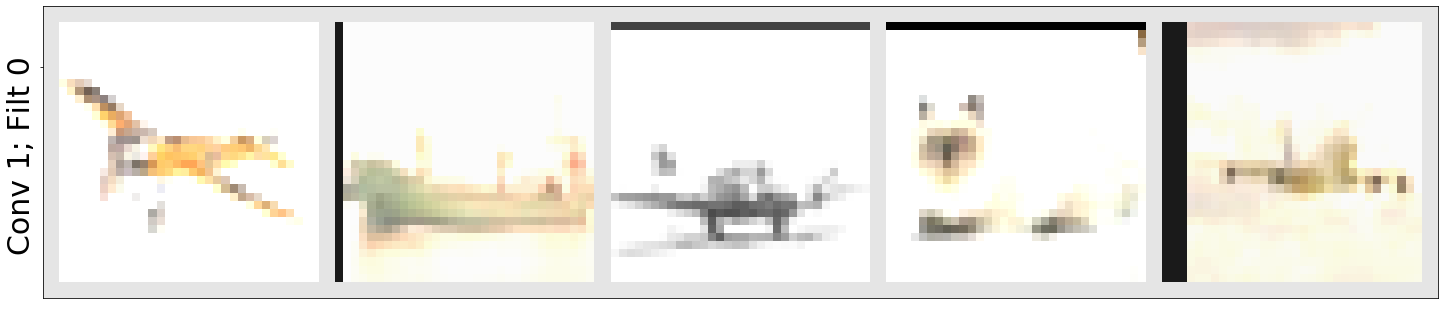

In [561]:
grid = torchvision.utils.make_grid(torch.tensor(topk_image['layer_1_filt_0']), nrow=5, pad_value=0.9)


plt.figure(figsize=(25, 25))

plt.yticks([7], ['Conv 1; Filt 0'], size = 30, rotation = 90)
plt.xticks([])
# plt.axis(False)
plt.imshow(np.transpose(grid, (1, 2, 0)))

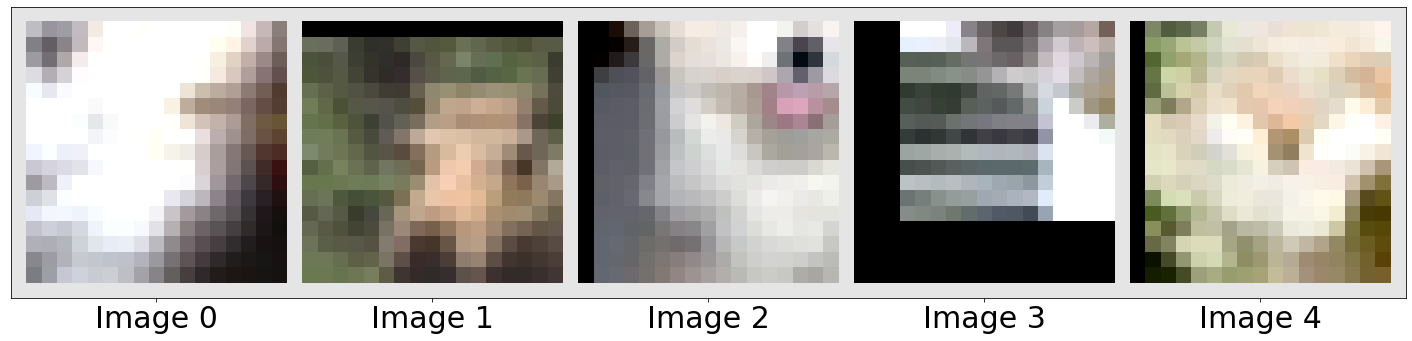

In [559]:
grid = torchvision.utils.make_grid(torch.tensor(best_patches['layer_5_filt_1'][1:]), nrow=5, padding=1, pad_value=0.9)

plt.figure(figsize=(25, 25))

# plt.yticks([3], ['Conv 2; Filt 0'], size = 30, rotation = 45)
plt.xticks([9 + (w)*18 for w in range(5)], 
  ['Image %i'%w for w in range(5)], size = 30)

plt.yticks([])
# plt.axis(False)
plt.imshow(np.transpose(grid, (1, 2, 0)))

### The feature map sums are same as above. Hence, *verified* that these are the same patches.

In [562]:
model = Network(64, 2, 3, 1, (3, 32, 32), 0.3, 5, 1)
model = model.eval()

# Load the model parameters
checkpoint = torch.load(MODEL_FILE)
model.load_state_dict(checkpoint)
outputs = model(torch.tensor(best_patches['layer_5_filt_1'][1:]))

for i in outputs:
    print(torch.sum(i))

Returned after 5 conv+bn layer
tensor(58.2312, grad_fn=<SumBackward0>)
tensor(14.0465, grad_fn=<SumBackward0>)
tensor(31.0607, grad_fn=<SumBackward0>)
tensor(20.2201, grad_fn=<SumBackward0>)
tensor(5.7695, grad_fn=<SumBackward0>)
